# Train Simple Image Classifier

Task: Train a simple image classifier using logistic regression and cross-entropy loss

## Setup

In [1]:
from fastai.vision.all import *

import sys
if sys.platform == "darwin":
    # https://stackoverflow.com/a/64855500/69707
    import os
    os.environ['OMP_NUM_THREADS'] = '1'

Load up the MNIST dataset. It has 10 digits.

In [3]:
path = untar_data(URLs.MNIST)

Create a subset of the images, so we train faster. We do this by taking 500 random images of each digit.

In [4]:
set_seed(0)
num_imgs_per_digit = 500
items = L([
    p
    for split in ['training', 'testing']
    for digit in range(10)
    for p in (path/split/str(digit)).ls().shuffle()[:num_imgs_per_digit]
])

Create the `dataloaders`. We need a slightly special `ImageBlock` because we want grayscale images.

In [5]:
block = DataBlock(
    blocks=(ImageBlock(PILImageBW), CategoryBlock),
    get_y = parent_label,
    splitter=GrandparentSplitter(train_name='training', valid_name="testing"),
)
dataloaders = block.dataloaders(items, bs=16)
print(f"{dataloaders.train.n} training images, {dataloaders.valid.n} validation images")

5000 training images, 5000 validation images


Let's inspect a batch of data.

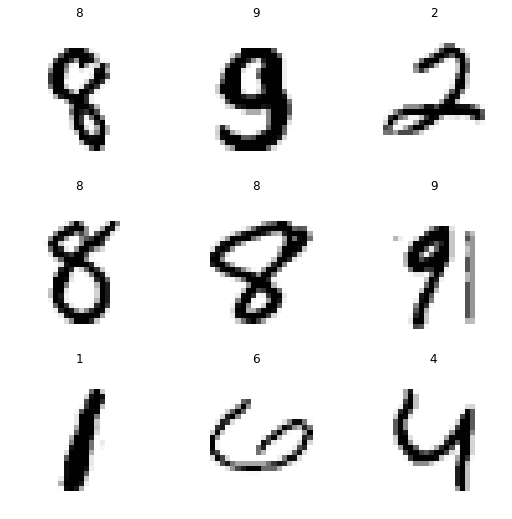

In [6]:
dataloaders.train.show_batch()

In [7]:
print(f"Available categories: {dataloaders.train.vocab}")

Available categories: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Task



Let's make a neural network to predict which digit was written, using the raw pixel values. We'll keep it at a *single* layer today, so this is actually just a fancy way of doing *logistic regression*. But it'll give us a chance to work with minibatches and loss functions.

Step 1: Create a linear layer of the appropriate dimensionality.

- Like we did in Homework 4, we'll flatten the images before giving them to the linear layer. They are 28 pixels square.
- Unlike in Homework 4, we're trying to predict which of 10 digits. So think about the output dimensionality.
- We'll turn `bias` off because it's redundant in this setting.

In [8]:
# linear_1 = nn.Linear(in_features=..., out_features=..., bias=False)
linear_1 = nn.Linear(in_features=784, out_features=10, bias=False)
model = nn.Sequential(
    nn.Flatten(),
    linear_1,
)

We test out our model on one batch of data. First, let's get a batch.

In [9]:
images, labels = dataloaders.train.one_batch()
images = cast(images, Tensor) # work around a fastai quirk
labels = cast(labels, Tensor)
images.shape

torch.Size([16, 1, 28, 28])

In case we're running on a machine with a GPU, the data loader might put images on the GPU -- but the model is still on CPU. So we'll move the model to the same device as the images.

In [10]:
model.to(images.device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=False)
)

Now we call the model to see what it returns.

In [11]:
logits = model(images)
assert logits.shape == (16, 10)
logits.shape

torch.Size([16, 10])

Think about why `logits.shape` contains those two numbers. 

In [12]:
labels

tensor([0, 9, 8, 6, 0, 6, 8, 3, 1, 6, 5, 0, 0, 7, 7, 9], device='cuda:0')

Now let's compute the cross-entropy loss. We'll use [`F.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy) from PyTorch, which has the following basic signature (simplified somewhat from the official docs):

```python
F.cross_entropy(
  logits: Tensor[Batch, Categories], # the unnormalized scores of each class, for each item in the batch
  target: TensorCategory[Batch],     # the correct label index (an int) for each item in the class
  reduction: str = 'mean'            # whether to return a single number for the average loss across the batch ('mean') or not ('none')
  label_smoothing: float = 0.0       # how much label smoothing to apply (none by default)
)
```

Let's try it on our logits and labels for this batch.

In [13]:
loss = F.cross_entropy(logits, labels, reduction='none')
loss

tensor([2.3661, 2.2252, 2.2272, 2.6011, 2.4279, 2.6860, 2.0244, 2.5572, 2.1823,
        2.1618, 2.1997, 2.4420, 2.4490, 2.2873, 2.3576, 2.2243],
       device='cuda:0', grad_fn=<NllLossBackward0>)

In [14]:
loss.mean()

tensor(2.3387, device='cuda:0', grad_fn=<MeanBackward0>)

We can use `argmax` to ask *which* category got the highest probability for each label. This will be useful for compting a *metric* like accuracy.

In [15]:
predictions = logits.argmax(dim=1)
print(predictions.shape)
predictions

torch.Size([16])


tensor([1, 8, 2, 1, 4, 7, 8, 4, 8, 5, 3, 1, 7, 8, 8, 0], device='cuda:0')

Now, fill in the blanks in the code below to train the model. **Make sure you understand what each line is doing.**

Epoch  0: loss=1.45, train accuracy 3482/4992
Epoch  1: loss=1.15, train accuracy 4142/4992
Epoch  2: loss=1.00, train accuracy 4238/4992
Epoch  3: loss=0.90, train accuracy 4286/4992
Epoch  4: loss=0.83, train accuracy 4329/4992
Epoch  5: loss=0.78, train accuracy 4356/4992
Epoch  6: loss=0.74, train accuracy 4384/4992
Epoch  7: loss=0.70, train accuracy 4399/4992
Epoch  8: loss=0.68, train accuracy 4410/4992
Epoch  9: loss=0.65, train accuracy 4423/4992


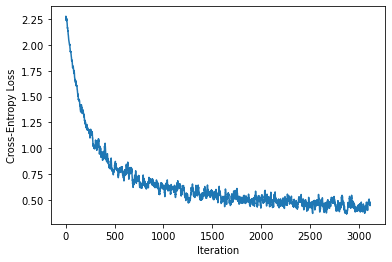

In [16]:
num_epochs = 10
learning_rate = .01
losses = []

# Re-initialize the parameters of the model, so training restarts when this block starts.
linear_1.reset_parameters()

for epoch in range(num_epochs):
    # Keep track of some things for each epoch.
    total_images = 0
    total_correct = 0

    # Loop over the training data in batches.
    for images, labels in dataloaders.train:
        images = cast(images, Tensor) # work around a quirk in fastai, ignore this
        labels = cast(labels, Tensor)
        
        # logits = ...
        logits = model(images)
        # loss = ...
        loss = F.cross_entropy(logits, labels) # automatically takes the mean

        # take an SGD step.
        loss.backward()
        for parameter in model.parameters():
            parameter.data -= learning_rate * parameter.grad
        model.zero_grad()

        # Track metrics
        predictions = logits.argmax(axis=1)
        num_accurate = (predictions == labels).sum()
        total_images += len(labels)
        total_correct += num_accurate

        # Track losses.
        # The .item method converts a 1-element tensor to a Python number.
        losses.append(loss.item())

    # Epoch done, print some stats.
    avg_loss_this_epoch = np.mean(losses[-total_images:])
    print(f"Epoch {epoch:2d}: loss={avg_loss_this_epoch:.2f}, train accuracy {total_correct:3d}/{total_images}")

# Plot the un-smoothed loss
#plt.plot(losses)
# Plot a smoothed version of the loss (easier to see the trend)
pd.Series(losses).ewm(alpha = .1).mean().plot()
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss");

Let's inspect the weights of our trained network. Since we have a single layer, it's relatively easy to do this. First, look at the weights of the `linear_1` layer:

In [17]:
linear_1.weight.shape

torch.Size([10, 784])

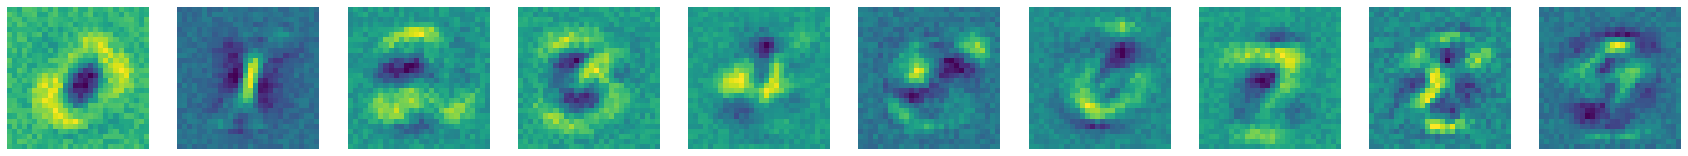

In [18]:
weight_images = linear_1.weight.data.view((10, 28, 28))
show_images(weight_images)

## Analysis

Q1: Why is `logits.shape` 16 by 10?

*your answer here*

Q2:  Before we trained the model (i.e., it just had random weights), the cross entropy was all about the same number. What was that number, and why? Hint:

In [19]:
np.log(10)

2.302585092994046

*your answer here*

Q3: Adjust the learning rate parameter. Give an example of a learning rate that is too high, one that is too low, and one that is good. For each, explain your answer by describing what the loss curve looks like; how do its *shape* and its *values* indicate good or bad training?

*your answer here*

Q4: Why the weight images look the way they do? (Why might they look similar to the digits in question? Why might they look not exactly like the digits in question?)

*your answer here*

## Extension

PyTorch gives us *optimizer* objects that do all the work of updating parameters. It not only saves code, it lets us swap in fancier optimizers. 

1. Compare this code with the code block above.
2. Fill in the blanks in the same way and observe how you get the same result with fewer lines of code.
3. Replace `SGD` with `AdamW` and compare the results.

Epoch  0: loss=1.44, train accuracy 3539/4992
Epoch  1: loss=1.15, train accuracy 4159/4992
Epoch  2: loss=0.99, train accuracy 4231/4992
Epoch  3: loss=0.90, train accuracy 4276/4992
Epoch  4: loss=0.83, train accuracy 4327/4992
Epoch  5: loss=0.77, train accuracy 4358/4992
Epoch  6: loss=0.73, train accuracy 4383/4992
Epoch  7: loss=0.70, train accuracy 4401/4992
Epoch  8: loss=0.67, train accuracy 4400/4992
Epoch  9: loss=0.65, train accuracy 4428/4992


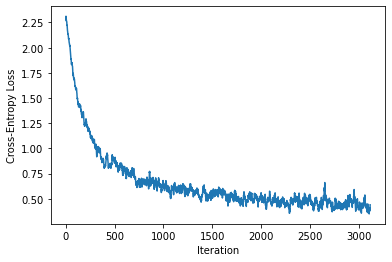

In [20]:
#-out
num_epochs = 10
learning_rate = .01
losses = []

# Initialize the optimizer.
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

# Re-initialize the parameters of the model, so training restarts when this block starts.
linear_1.reset_parameters()
for epoch in range(num_epochs):
    # Keep track of some things for each epoch.
    total_images = 0
    total_correct = 0
    for images, labels in dataloaders.train:
        images = TensorBase(images) # work around a quirk in fastai, ignore this
        # logits = ...
        logits = model(images)
        # loss = ...
        loss = F.cross_entropy(logits, labels) # automatically takes the mean

        # take an SGD step.
        loss.backward()
        optimizer.step()
        model.zero_grad()

        # Track metrics
        predictions = logits.argmax(axis=1)
        num_accurate = (predictions == labels).sum()
        total_images += len(labels)
        total_correct += num_accurate

        # Track losses.
        losses.append(loss.item())

    # Epoch done, print some stats.
    avg_loss_this_epoch = np.mean(losses[-total_images:])
    print(f"Epoch {epoch:2d}: loss={avg_loss_this_epoch:.2f}, train accuracy {total_correct:3d}/{total_images}")

# Plot the un-smoothed loss
#plt.plot(losses)
# Plot a smoothed version of the loss (easier to see the trend)
pd.Series(losses).ewm(alpha = .1).mean().plot()
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss");

Comments from grading this assignment last year:

- Why 10 output features? One score (logit) for each of the 10 digits.
- Describe *why* you conclude that the loss curves are bad.
- Learning rates: the basic shape will typically be something like 1/x, but with differences in shape and, most significantly, ending values.
- Think more about why the weights sorta look like the digits in this case. See below.
- The weight images won't look exactly like a digit even at convergence--why?

Notes (mostly generic notes I'm giving to everyone):

- The initialization was good because the predicted probabilities before training ended up approximately equal across the 10 categories, so the model was rightly telling us "I don't know" before training. We could see that because the cross-entropy (log loss) was about -ln(1/10), so whatever the true digit was, the classifier was giving it a probability of about 1/10. So the loss wasn't huge early in training, so the gradient updates weren't huge either.
- Look at both the shape of the loss curve and also the values it achieves. Note, for example, that both too-small and too-large learning rates end up with loss values that are much higher than what you see with a reasonable learning rate, though they take a different trajectory to get there. (Why?)
  - Importantly: the problem with learning rates like 1.0 or 0.5 isn't the steep initial descent (actually that can be a good thing!), it's the fact that the weights jump around too much between batches so the weights never get close enough to their best values. You can see this because the loss jumps around too.
- The weight images *do* look like the digits because the dot product that `linear_1` does is basically comparing them with the input images, pixel-by-pixel, to see how much overlap there is.
- The weight images *don't* look like the digits because:
  - they're trained on the *differences* between the digit images, not the images themselves (think about how this relates to the softmax properties we studied in hw5),
  - all of the values could have been shifted up or down by a constant without affecting the result, so negative values aren't meaningful per se (if we had used any kind of *regularization* this wouldn't be true anymore), and
  - some digits can be drawn in different ways. Without any hidden layers to build up representations, the only thing this network can do with digits that are drawn different ways is to take the average of the two.
- This model massively underfits--much better performance is possible. (But hm, look at the weight images... could it have also been *overfitting*? Yes you can have both at the same time.)
